In [1]:
import argparse
import json
import os
import pathlib
import pickle as pkl
import shutil
import sys
import time
import warnings
from collections import defaultdict
from typing import Dict, List, Optional

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

### schema
import uproot
from coffea import nanoevents, processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import candidate, vector

import mplhep as hep

plt.style.use(hep.style.CMS)

### awkward 1.10.0
sys.path.append("../")

nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Missing cross-reference index ")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%load_ext autoreload
%autoreload 2

# Weaver output

In [567]:
! ls ../experiments/mass_regression/predict

pred_custom.root        pred_custom_highlr.root pred_test.root
pred_custom2.root       pred_custom_v2.root


In [579]:
events = {}
events["config1"] = uproot.open("../experiments/mass_regression/predict/pred_test.root")["Events"]
events["config2"] =  uproot.open("../experiments/mass_regression/predict/pred_custom.root")["Events"]
events["config2_lowlr"] =  uproot.open("../experiments/mass_regression/predict/pred_custom_highlr.root")["Events"]

for key in events.keys():
    print(events[key].keys())
    break

['target_mass', 'output_target_mass', 'fj_pt', 'fj_msoftdrop', 'fj_eta', 'fj_phi', 'class_H', 'class_W', 'class_QCD', 'class_Top', 'fj_ParT_mass', 'fj_ParT_inclusive_score']


In [569]:
events[key]["target_mass"].array()

<Array [125, 125, 125, ... 48.3, 43.5, 49.8] type='627938 * float64'>

In [570]:
events[key]["output_target_mass"].array()

<Array [117, 110, 115, ... 75.6, 62.1, 55.2] type='627938 * float32'>

In [571]:
events[key]["fj_ParT_inclusive_score"].array()

<Array [0.817, 0.924, 0.531, ... 0.019, 0.138] type='627938 * float64'>

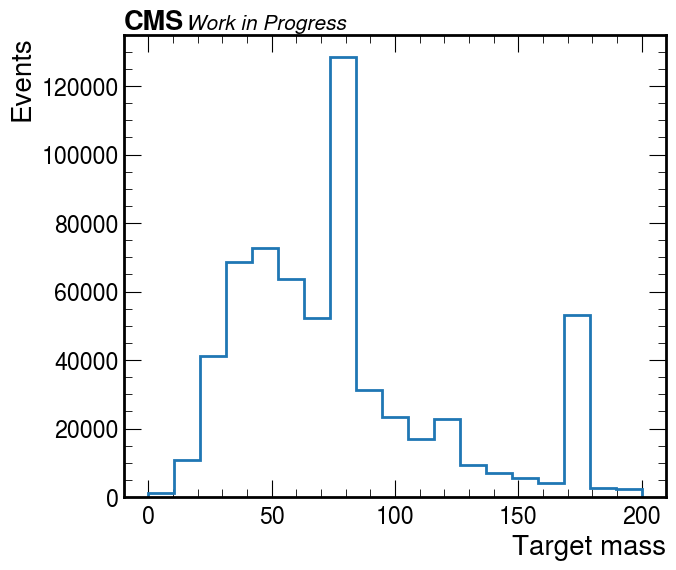

In [572]:
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(7, 6))

ax.hist(events[key]["target_mass"].array(), bins=np.linspace(0,200,20), histtype="step", linewidth=2, label="target_mass")

ax.set_ylabel("Events");  
hep.cms.lumitext(
#     "Matched Higgs samples", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_xlabel("Target mass")
plt.savefig("/Users/fmokhtar/Desktop/hww/mass_regression/target_mass.pdf")

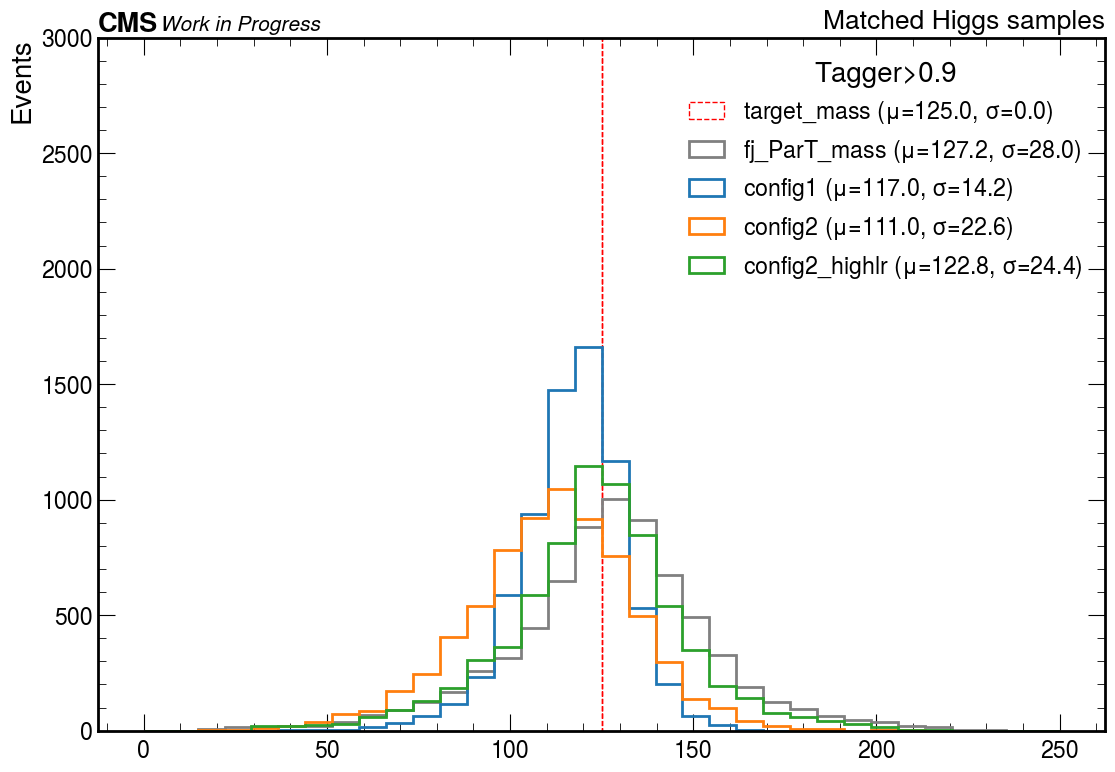

In [573]:
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(13, 9))

matched = (events[key]["target_mass"].array()==125)

tagger_wp = 0.9
tagger_cut = events[key]["fj_ParT_inclusive_score"].array() > tagger_wp

x = events[key]["target_mass"].array()[matched & tagger_cut]
ax.hist(x, color="red", histtype="step", linestyle="--", label=rf"target_mass ($\mu$={np.mean(x)}, $\sigma$={np.std(x)})")

x = events[key]["fj_ParT_mass"].array()[matched & tagger_cut]
ax.hist(x,bins=np.linspace(0,250,35),  color="grey", histtype="step", linewidth=2, label=rf"fj_ParT_mass ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

for key in events:

    x = events[key]["output_target_mass"].array()[matched & tagger_cut]
    ax.hist(x,bins=np.linspace(0,250,35),  histtype="step", linewidth=2, label=rf"{key} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

if tagger_wp == 0:
    ax.legend(title=f"No tagger cut")
else:
    ax.legend(title=f"Tagger>{tagger_wp}")

ax.set_ylabel("Events");  
hep.cms.lumitext(
    "Matched Higgs samples", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_ylim(0,3000)
# ax.set_ylim(0,1500)

plt.savefig(f"/Users/fmokhtar/Desktop/hww/mass_regression/matched_higgs_{tagger_wp}.pdf")

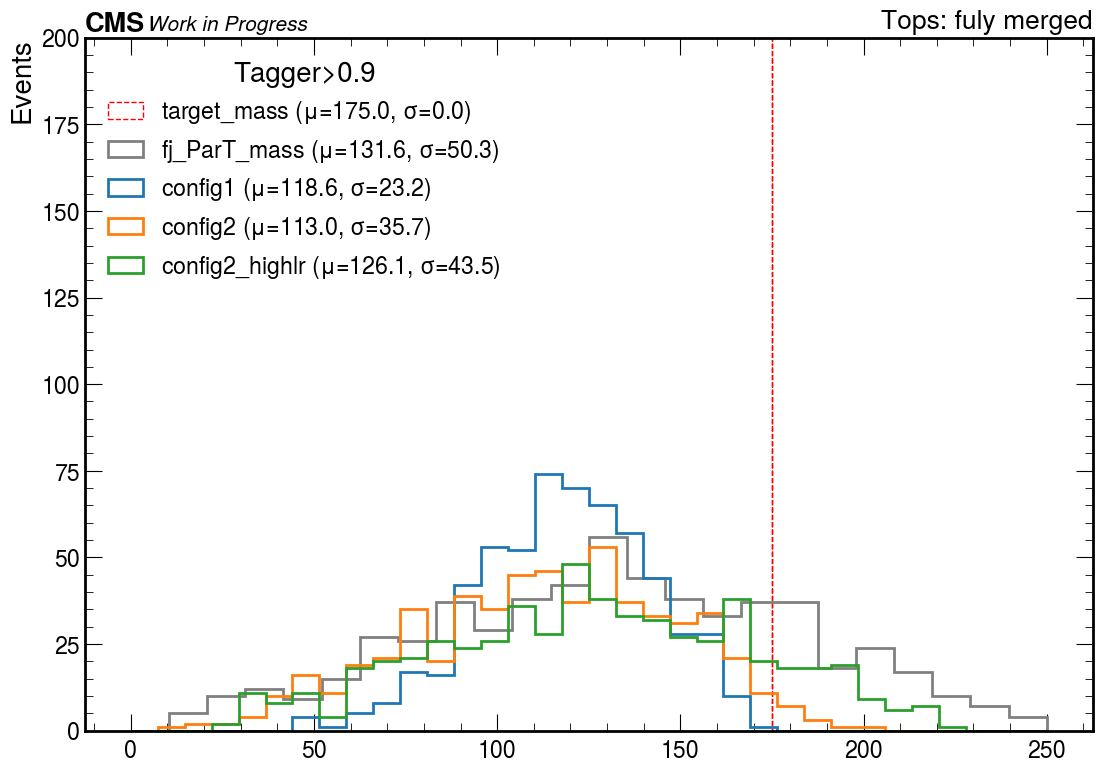

In [554]:
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(13, 9))

matched = (events_test["class_Top"].array()) & (events_test["target_mass"].array()==175)

tagger_wp = 0.9
tagger_cut = events_test["fj_ParT_inclusive_score"].array() > tagger_wp

x = events_test["target_mass"].array()[matched & tagger_cut]
ax.hist(x, color="red", histtype="step", linestyle="--", label=rf"target_mass ($\mu$={np.mean(x)}, $\sigma$={np.std(x)})")

x = events_test["fj_ParT_mass"].array()[matched & tagger_cut]
ax.hist(x,bins=np.linspace(0,250,25),  color="grey", histtype="step", linewidth=2, label=rf"fj_ParT_mass ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

for key in events:

    x = events[key]["output_target_mass"].array()[matched & tagger_cut]
    ax.hist(x,bins=np.linspace(0,250,35),  histtype="step", linewidth=2, label=rf"{key} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

if tagger_wp == 0:
    ax.legend(title=f"No tagger cut")
else:
    ax.legend(title=f"Tagger>{tagger_wp}")

ax.set_ylabel("Events");  
hep.cms.lumitext(
    "Tops: fuly merged", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_ylim(0,200)
# ax.set_ylim(0,15000)

plt.savefig(f"/Users/fmokhtar/Desktop/hww/mass_regression/top_fully_merged_{tagger_wp}.pdf")

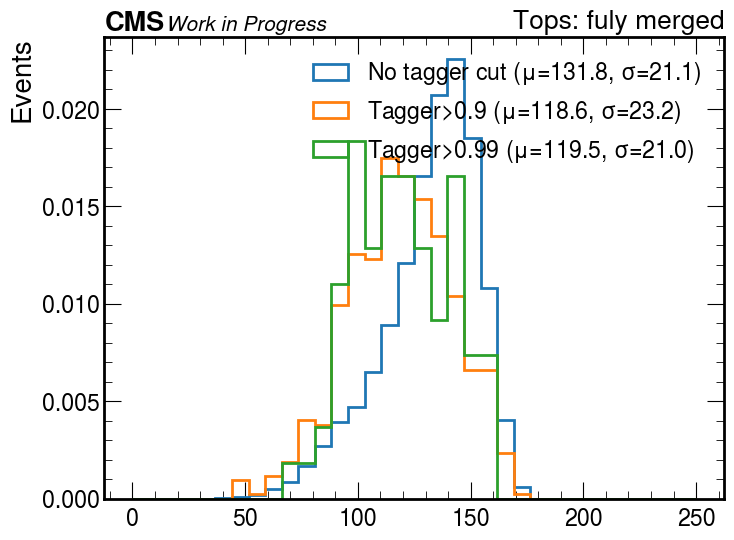

In [578]:
plt.rcParams.update({"font.size": 20})

# plot histogram
matched = (events_test["class_Top"].array()) & (events_test["target_mass"].array()==175)

for key in events:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for tagger_wp in [0, 0.9, 0.99]:

        tagger_cut = events_test["fj_ParT_inclusive_score"].array() > tagger_wp
        x = events[key]["output_target_mass"].array()[matched & tagger_cut]

        if tagger_wp == 0:
            title = f"No tagger cut"
        else:
            title = f"Tagger>{tagger_wp}"
    
        ax.hist(x, bins=np.linspace(0,250,35), density=True, histtype="step", linewidth=2, label=rf"{title} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

    ax.set_ylabel("Events");  
    hep.cms.lumitext(
        "Tops: fuly merged", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
#     ax.set_ylim(0,200)
    # ax.set_ylim(0,15000)
    ax.legend()
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/mass_regression/top_fully_merged_{key}.pdf")
    break

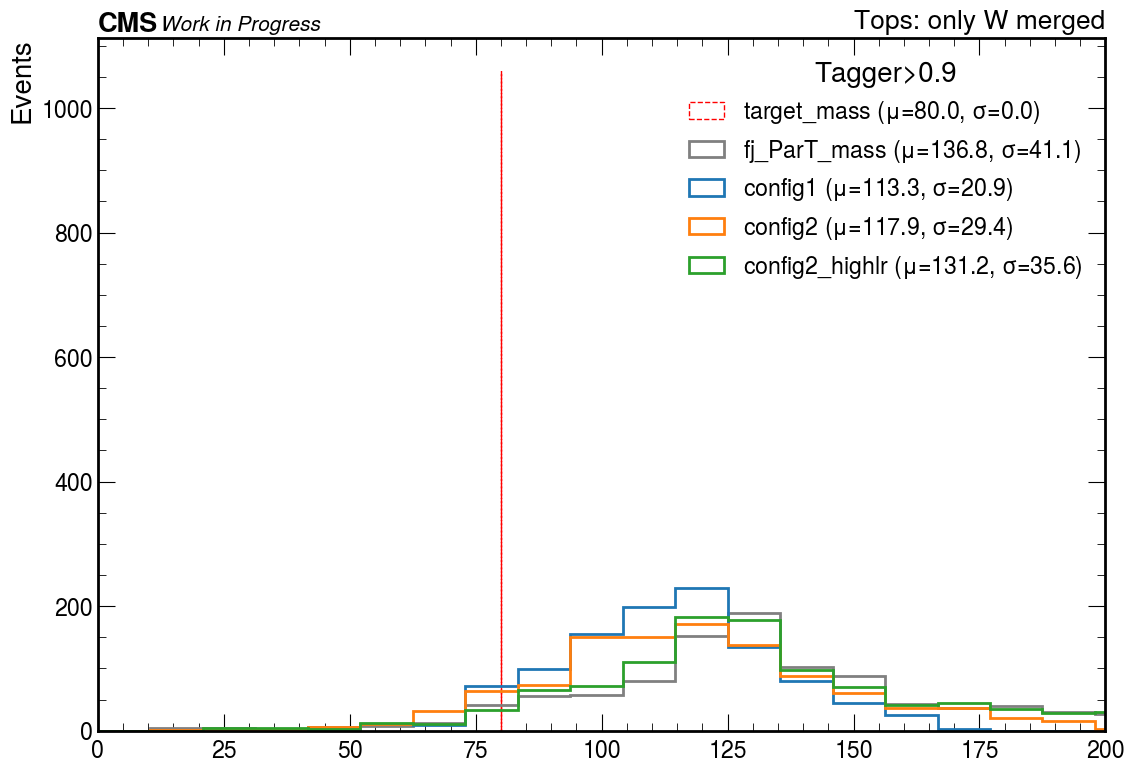

In [565]:
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(13, 9))

matched = (events_test["class_Top"].array()) & (events_test["target_mass"].array()==80)

tagger_wp = 0.9
tagger_cut = events_test["fj_ParT_inclusive_score"].array() > tagger_wp

x = events_test["target_mass"].array()[matched & tagger_cut]
ax.hist(x, color="red", histtype="step", linestyle="--", label=rf"target_mass ($\mu$={np.mean(x)}, $\sigma$={np.std(x)})")

x = events_test["fj_ParT_mass"].array()[matched & tagger_cut]
ax.hist(x,bins=np.linspace(0,250,25),  color="grey", histtype="step", linewidth=2, label=rf"fj_ParT_mass ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

for key in events:

    x = events[key]["output_target_mass"].array()[matched & tagger_cut]
    ax.hist(x,bins=np.linspace(0,250,25),  histtype="step", linewidth=2, label=rf"{key} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

if tagger_wp == 0:
    ax.legend(title=f"No tagger cut")
else:
    ax.legend(title=f"Tagger>{tagger_wp}")

ax.set_ylabel("Events");  
hep.cms.lumitext(
    "Tops: only W merged", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_xlim(0,200)
# ax.set_ylim(0,15000)
# ax.set_ylim(0,1500)

plt.savefig(f"/Users/fmokhtar/Desktop/hww/mass_regression/top_half_merged_{tagger_wp}.pdf")

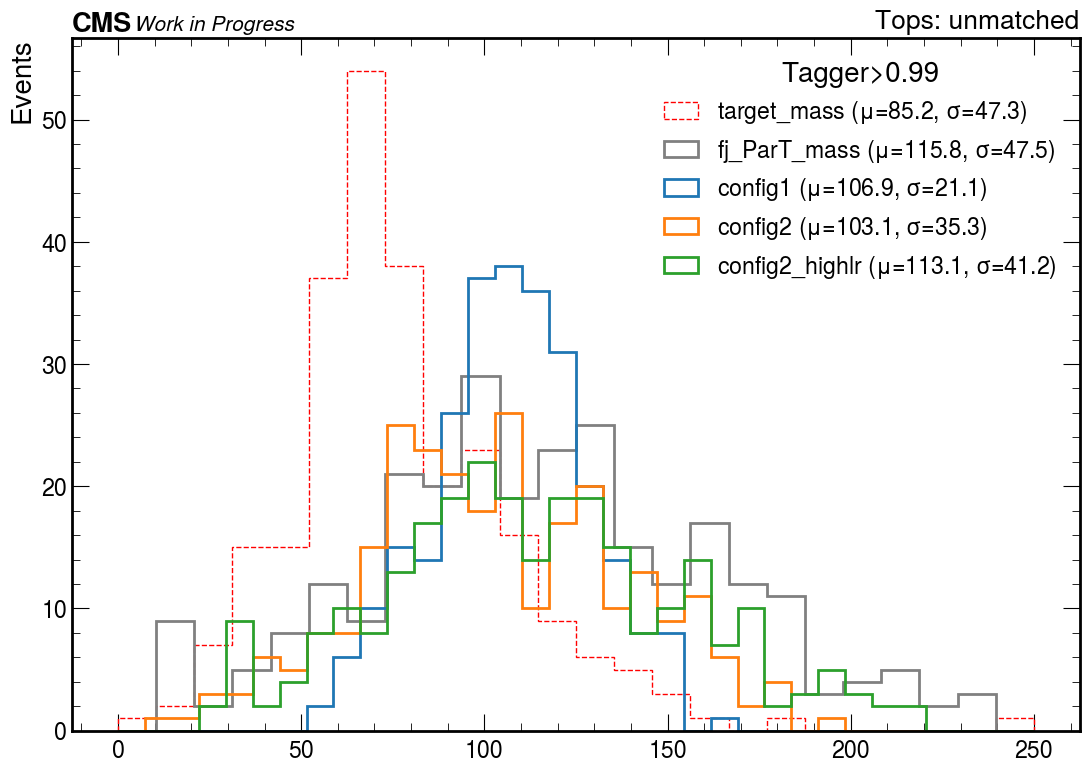

In [566]:
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(13, 9))

matched = (events_test["class_Top"].array()) & (events_test["target_mass"].array()!=175) & (events_test["target_mass"].array()!=80)

tagger_wp = 0.99
tagger_cut = events_test["fj_ParT_inclusive_score"].array() > tagger_wp

x = events_test["target_mass"].array()[matched & tagger_cut]
ax.hist(x, bins=np.linspace(0,250,25), color="red", histtype="step", linestyle="--", label=rf"target_mass ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

x = events_test["fj_ParT_mass"].array()[matched & tagger_cut]
ax.hist(x, bins=np.linspace(0,250,25),  color="grey", histtype="step", linewidth=2, label=rf"fj_ParT_mass ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

for key in events:

    x = events[key]["output_target_mass"].array()[matched & tagger_cut]
    ax.hist(x,bins=np.linspace(0,250,35),  histtype="step", linewidth=2, label=rf"{key} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})")

if tagger_wp == 0:
    ax.legend(title=f"No tagger cut")
else:
    ax.legend(title=f"Tagger>{tagger_wp}")

ax.set_ylabel("Events");  
hep.cms.lumitext(
    "Tops: unmatched", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_ylim(0,200)
# ax.set_ylim(0,60000)

plt.savefig(f"/Users/fmokhtar/Desktop/hww/mass_regression/top_unmatched_{tagger_wp}.pdf")

KeyError: 'class_Top'

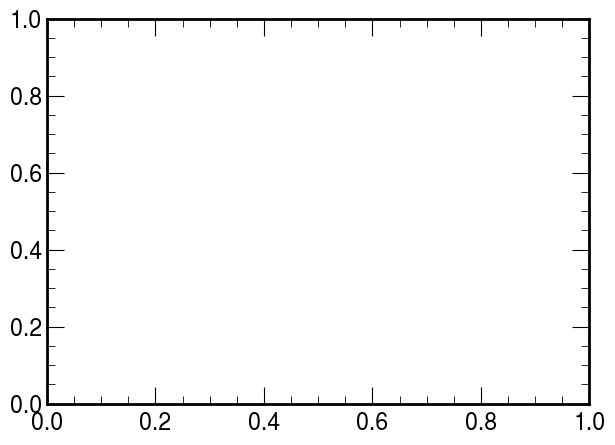

In [549]:
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

matched = (events["class_Top"].array()) & (events["target_mass"].array()!=175) & (events["target_mass"].array()!=80) & (events["fj_Top_nquarksnob"].array()!=2)

tagger_cut = 0
ax.hist(events["fj_ParT_mass"].array()[matched & (tagger_score>tagger_cut)], bins=np.linspace(0,250,30), histtype="step", linewidth=2, label=f"tagger>{tagger_cut}", density=True)
tagger_cut = 0.9
ax.hist(events["fj_ParT_mass"].array()[matched & (tagger_score>tagger_cut)], bins=np.linspace(0,250,30), histtype="step", linewidth=2, label=f"tagger>{tagger_cut}", density=True)
tagger_cut = 0.95
ax.hist(events["fj_ParT_mass"].array()[matched & (tagger_score>tagger_cut)], bins=np.linspace(0,250,30), histtype="step", linewidth=2, label=f"tagger>{tagger_cut}", density=True)

ax.legend()
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "Unmatched Top (with fj_Top_nquarksnob!=2)", ax=ax, fontsize=20
)
# hep.cms.text("Work in Progress", ax=ax, fontsize=15)